In [1]:

import torch
from transformer_lens import HookedTransformer
import numpy as np
from tqdm import tqdm
import re
import random 
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
torch.set_grad_enabled(False)


In [4]:
model_pythia = ["pythia-410m-deduped", "pythia-1.4b-deduped", "pythia-2.8b-deduped", "pythia-6.9b-deduped"]

model_name = model_pythia[-2]
hooked_model = HookedTransformer.from_pretrained(model_name, device='cuda:1')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-2.8b-deduped into HookedTransformer


In [5]:

dataset = load_dataset("EleutherAI/the_pile_deduplicated", split='train', streaming=True)

Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

In [6]:
#this is the size of the dataset    
sample_size = 5000

In [7]:

amount = 10000

# Define the set of punctuation characters to check
punctuation_chars = set("()[]{}.,;:!?-/\\\"'`~@#$%^&*_+=|<>")
letters= set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")

# Initialize an empty list to aggregate four-token words with context
prompts_single = []

for prompt in tqdm(dataset.take(amount)):
    split = prompt['text'].split()
    
    # Filter out words with unwanted characters using regex and check for all caps
    filtered_words = [
        word for word in split
        if not re.search(r'[\n\d]', word) and
        not any(char in punctuation_chars for char in word) and
        not word.isupper()
    ]
    
    # We need to find four-token words with preceding context of 10 tokens
    try:
        i=0
        context = filtered_words[i:i+16]
        word = filtered_words[i+16]
    except:
        continue
    prompt_context = ' '.join(context) + ' ' + word
    tokens = hooked_model.to_str_tokens(prompt_context, prepend_bos=False)
    if word.lower() == word and all(char in letters for char in word) and " " + word=="".join(tokens[-1:]):
        prompt_context = ' '.join(context) + ' ' + word
        prompts_single.append(prompt_context)
        if len(prompts_single) >= sample_size:
            break   



6737it [00:09, 708.59it/s]


In [8]:

amount = 500

# Define the set of punctuation characters to check
punctuation_chars = set("()[]{}.,;:!?-/\\\"'`~@#$%^&*_+=|<>")
letters= set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")

# Initialize an empty list to aggregate four-token words with context
prompts = []
answers = []

for prompt in tqdm(dataset.take(amount)):
    split = prompt['text'].split()
    
    # Filter out words with unwanted characters using regex and check for all caps
    filtered_words = [
        word for word in split
        if not re.search(r'[\n\d]', word) and
        not any(char in punctuation_chars for char in word) and
        not word.isupper()
    ]
    
    # We need to find four-token words with preceding context of 10 tokens
    for i in range(len(filtered_words) - 16):
        context = filtered_words[i:i+16]
        word = filtered_words[i+16]

        prompt_context = ' '.join(context) + ' ' + word
        tokens = hooked_model.to_str_tokens(prompt_context, prepend_bos=False)
        if word.lower()== word and all(char in letters for char in word) and " " + word=="".join(tokens[-4:]):
            prompt_context = ' '.join(context) + ' ' + word
            prompts.append(prompt_context)
            answers.append(word)
            if len(prompts) >= sample_size:
                break   

# Check if we have collected enough prompts
if len(prompts) < 10:
    print("Not enough 3-token words found.")
else:
    print("Collected dataset: ", prompts)


500it [05:46,  1.44it/s]

Collected dataset:  ['Adobe all tools or frameworks already had some knowledge One big change for me was that livestreamed', 'in My own stream was probably boring to watch since was coding for the most But livestreaming', 'But in the didn’t have time to implement the sauce selection all pasta ended up using bolognese', 'assemble a simple salad from Of course while I’m at the can’t not get some five peppercorn', 'September Before the foreclosure Trujillo removed or destroyed property in the including kitchen interior and exterior doorjambs', 'its intent to require such retroactive consider this statement by the supreme court about its own jurisprudence', 'the known including those present in just some cells due to mosaicism The significance of many nontruncating', 'and imaging will be employed to generate a predictive algorithm for Disease modifiers to severe via biallelic', 'be one of just convertibles produced for the last year of convertible production in The has carburetors', 'dusty

In [9]:
prompts_single = random.sample(prompts_single, len(prompts))

In [10]:
attention_scores_single = []
for input in tqdm(prompts_single):
    pattern_filter = lambda name: any(name.endswith(f"hook_{s}") for s in ["pattern"])
    logs, cache = hooked_model.run_with_cache(input, names_filter=pattern_filter,remove_batch_dim=True)
    tokens = hooked_model.to_str_tokens(input)
    cache.to("cpu")
    vals = cache.stack_activation("pattern").detach().cpu().numpy()
    vals = vals[:,:,-16:, -16:]
    attention_scores_single.append(vals)

100%|██████████| 988/988 [00:45<00:00, 21.71it/s]


In [11]:
attention_scores_single = np.array(attention_scores_single)

mean_attention_scores_single = np.mean(attention_scores_single, axis=0)

In [12]:
attention_scores = []
for input in tqdm(prompts):
    pattern_filter = lambda name: any(name.endswith(f"hook_{s}") for s in ["pattern"])
    logs, cache = hooked_model.run_with_cache(input, names_filter=pattern_filter,remove_batch_dim=True)
    tokens = hooked_model.to_str_tokens(input)
    cache.to("cpu")
    vals = cache.stack_activation("pattern").detach().cpu().numpy()
    vals = vals[:,:,-16:, -16:]
    attention_scores.append(vals)

100%|██████████| 988/988 [00:46<00:00, 21.45it/s]


In [13]:
attention_scores = np.array(attention_scores)
mean_attention_scores = np.mean(attention_scores, axis=0)

In [14]:
diff = mean_attention_scores_single - mean_attention_scores
diff = np.abs(diff)

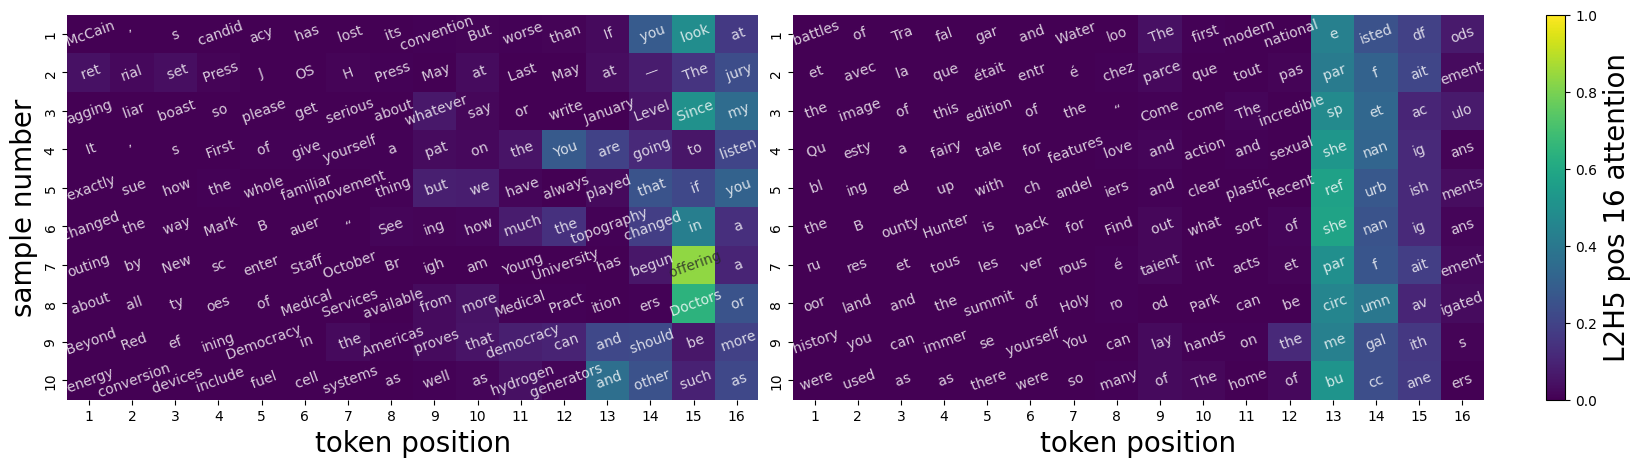

In [38]:


# Set random seed for reproducibility
np.random.seed(0)
random.seed(0)

# Initialize arrays for heatmaps
single_token = np.zeros((10, 16))
four_token = np.zeros((10, 16))

# Filter valid indices for single-token and four-token prompts
valid_single_indices = list(range(len(prompts_single)))
valid_four_indices = [i for i in range(len(prompts)) if attention_scores[i, 1, 6, -1, -4] > 0.4 and attention_scores[i, 1, 6, -1, -3] > 0.23 and attention_scores[i, 1, 6, -1, -2] > 0.1 and attention_scores[i, 1, 6, -1, -6] < 0.07]

# Sample 10 indices from the valid indices
random_single = random.sample(valid_single_indices, 10)
random_four = random.sample(valid_four_indices, 10)

# Populate single_token array and token annotations
single_token_annotations = np.empty((10, 16), dtype=object)
for i in range(10):
    single_token[i] = attention_scores_single[random_single[i], 1, 6, -1, :]
    tokens = hooked_model.to_str_tokens(prompts_single[random_single[i]])[-16:]
    for j in range(16):
        single_token_annotations[i, j] = tokens[j]

# Populate four_token array and token annotations
four_token_annotations = np.empty((10, 16), dtype=object)
for i in range(10):
    four_token[i] = attention_scores[random_four[i], 1, 6, -1, :]
    tokens = hooked_model.to_str_tokens(prompts[random_four[i]])[-16:]
    for j in range(16):
        four_token_annotations[i, j] = tokens[j]

# Plot the heatmaps
fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.05})
sns.heatmap(single_token, ax=axs[0], cmap='viridis', vmin=0, vmax=1, annot=single_token_annotations, fmt='', annot_kws={"size": 10, "rotation": 20}, cbar=False)
sns.heatmap(four_token, ax=axs[1], cmap='viridis', vmin=0, vmax=1, annot=four_token_annotations, fmt='', annot_kws={"size": 10, "rotation": 20}, cbar=False)

# Add a single color bar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('L2H5 pos 16 attention', fontsize=20)
# mak y axis go from 1 to 10
# Set titles
for texts in [axs[0].texts, axs[1].texts]:
    for text in texts:
        text.set_alpha(0.8)  # Set the alpha transparency to 0.6
#label x axis and y axis
axs[0].set_xlabel("token position", fontsize=20)
axs[1].set_xlabel("token position", fontsize=20)
axs[0].set_ylabel("sample number", fontsize=20)
# axs[1].set_ylabel("Sample Index", fontsize=20)


axs[0].set_yticks(np.arange(10) + 0.5)
axs[0].set_yticklabels(np.arange(1, 11))
axs[1].set_yticks(np.arange(10) + 0.5)
axs[1].set_yticklabels(np.arange(1, 11))

axs[0].set_xticks(np.arange(16) + 0.5)
axs[0].set_xticklabels(np.arange(1, 17))
axs[1].set_xticks(np.arange(16) + 0.5)
axs[1].set_xticklabels(np.arange(1, 17))
#save pdf 
plt.savefig("single_four_token.pdf", bbox_inches='tight')
plt.show()

